# Data Preparation

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 500

## Import Data

In [2]:
loan_data_backup = pd.read_csv('loan_data_2007_2014.csv')

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loan_data = loan_data_backup.copy()

## General Preprocessing

### Preprocessing few continuous variables

In [4]:
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('\+ years', '') #replacing +10 with nothing
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year', str(0)) #replace <1 years with nothing
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('n/a',  str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' year', '')
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int']) #turn into numeric

In [5]:
loan_data["term_int"] = loan_data["term"].str.replace("months", "")
loan_data["term_int"] = loan_data["term_int"].str.replace(" ", "") # remove empty spaces
loan_data['term_int'] = pd.to_numeric(loan_data['term_int'])

In [6]:
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')
#offsetting due to some years not converting properly
loan_data["earliest_cr_line_date"].loc[loan_data["earliest_cr_line_date"] > pd.to_datetime("2018-01-01")] -= pd.DateOffset(years=100)

loan_data['mths_since_earliest_cr_line'] = round(pd.to_numeric((
                                            pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']) / 
                                            np.timedelta64(1, 'M'))) # getting the time in months



C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
loan_data['issue_date'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%y')
loan_data["mths_since_issue_d"] = round(pd.to_numeric(( pd.to_datetime('2017-12-01')-loan_data['issue_date'])/ 
                                            np.timedelta64(1, 'M'))) #converting into months

### Dummy variables

In [8]:
loan_data_dummies = [pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['sub_grade'], prefix = 'sub_grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
                     pd.get_dummies(loan_data['verification_status'], prefix = 'verification_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['loan_status'], prefix = 'loan_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['purpose'], prefix = 'purpose', prefix_sep = ':'),
                     pd.get_dummies(loan_data['addr_state'], prefix = 'addr_state', prefix_sep = ':'),
                     pd.get_dummies(loan_data['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ':')]

In [9]:
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)
loan_data = pd.concat([loan_data, loan_data_dummies], axis = 1)

In [10]:
pd.options.display.max_rows = 100
loan_data.isnull().sum()
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace = True)
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace = True)

loan_data['mths_since_earliest_cr_line'].fillna(0, inplace = True)
loan_data['acc_now_delinq'].fillna(0, inplace = True)
loan_data['total_acc'].fillna(0, inplace = True)
loan_data['pub_rec'].fillna(0, inplace = True)
loan_data['open_acc'].fillna(0, inplace = True)
loan_data['inq_last_6mths'].fillna(0, inplace = True)

   ### Defining the dependent variable

In [11]:
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default',
                                                               'Does not meet the credit policy. Status:Charged Off',
                                                               'Late (31-120 days)']), 0, 1)

### Train-test split

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(loan_data.drop('good_bad', axis = 1), 
                                                    loan_data['good_bad'], test_size = 0.2, random_state = 42)

In [13]:
#Weight of Evidence and information value

def woe_discrete(df, discrete_var_name, y):
    df = pd.concat([df[discrete_var_name], y], axis = 1)
    pivot = df.pivot_table(index = discrete_var_name, values= "good_bad", aggfunc = ("count", "mean")).rename(
                                                                columns={"count":"n_obs","mean":"prop_good"})
    pivot["prop_obs"] = pivot["n_obs"] / pivot["n_obs"].sum() #how common is each class
    pivot["n_good"] = pivot['prop_good'] * pivot['n_obs'] #counting number of good borrowers in each group
    pivot['n_bad'] = (1 - pivot['prop_good']) * pivot['n_obs'] #number of bad borrowers
    
    #percentage of good borrowers in the group compared to all good
    pivot['prop_n_good'] = pivot['n_good'] / pivot['n_good'].sum() 
    pivot['prop_n_bad'] = pivot['n_bad'] / pivot['n_bad'].sum()

    #calculating the weight of evidence using natural log
    pivot['WoE'] = np.log(pivot['prop_n_good'] / pivot['prop_n_bad'])
    pivot = pivot.sort_values(['WoE'])

    #calculating information value of the factor
    pivot['IV'] = (pivot['prop_n_good'] - pivot['prop_n_bad']) * pivot['WoE']
    pivot['IV'] = pivot['IV'].sum() #is the same for all members of the column
    return pivot


In [14]:
df_temp = woe_discrete(X_train, 'grade', y_train)
df_temp

,n_obs,prop_good,prop_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
grade,,,,,,,,,
G,2654.0,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459,0.288636
F,10530.0,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440,0.288636
E,28612.0,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267,0.288636
D,61498.0,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843,0.288636
C,100245.0,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503,0.288636
B,109730.0,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476,0.288636
A,59759.0,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830,0.288636


## Visualisation and preprocessing

### Train set

#### Grade variable

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.index.values)
    y = df_WoE['WoE']
    plt.figure(figsize = (18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.index.name)
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)
    plt.show()
    
plot_by_woe(df_temp)

<Figure size 1800x600 with 1 Axes>

In [16]:
df_temp
#Here I will keep all the values as they have big difference in weight of evidence

,n_obs,prop_good,prop_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
grade,,,,,,,,,
G,2654.0,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459,0.288636
F,10530.0,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440,0.288636
E,28612.0,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267,0.288636
D,61498.0,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843,0.288636
C,100245.0,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503,0.288636
B,109730.0,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476,0.288636
A,59759.0,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830,0.288636


#### Home ownership

In [17]:
df_temp = woe_discrete(X_train, 'home_ownership', y_train)
df_temp

,n_obs,prop_good,prop_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
home_ownership,,,,,,,,,
OTHER,137.0,0.795620,0.000367,109.0,28.0,0.000328,0.000687,-0.738602,inf
NONE,40.0,0.850000,0.000107,34.0,6.0,0.000102,0.000147,-0.363144,inf
RENT,150599.0,0.873870,0.403720,131604.0,18995.0,0.396099,0.465815,-0.162123,inf
OWN,33295.0,0.892536,0.089256,29717.0,3578.0,0.089442,0.087743,0.019170,inf
MORTGAGE,188956.0,0.903835,0.506546,170785.0,18171.0,0.514026,0.445608,0.142834,inf
ANY,1.0,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf


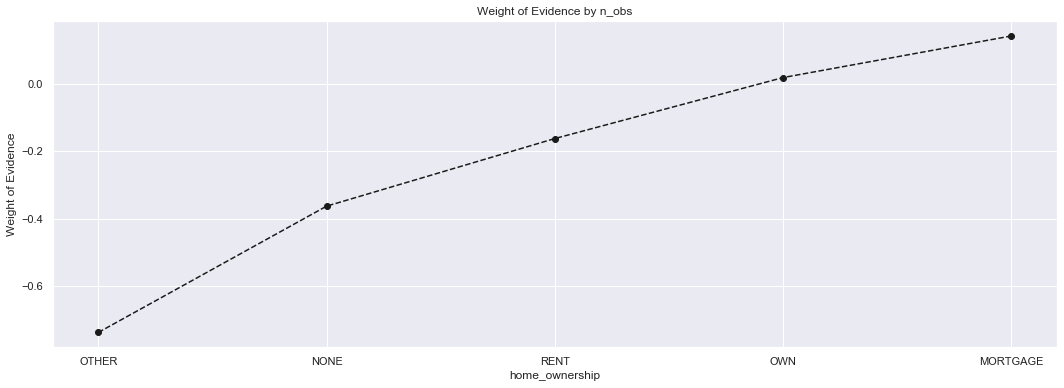

In [18]:
plot_by_woe(df_temp)

In [19]:
#Merging categories of the home ownership variable
#None, other, any have too few observations
X_train['home_ownership:RENT_OTHER_NONE_ANY'] = sum([X_train['home_ownership:RENT'], X_train['home_ownership:OTHER'],
                                                      X_train['home_ownership:NONE'],X_train['home_ownership:ANY']])

#### US state

In [20]:
df_temp = woe_discrete(X_train, 'addr_state', y_train)
#df_temp

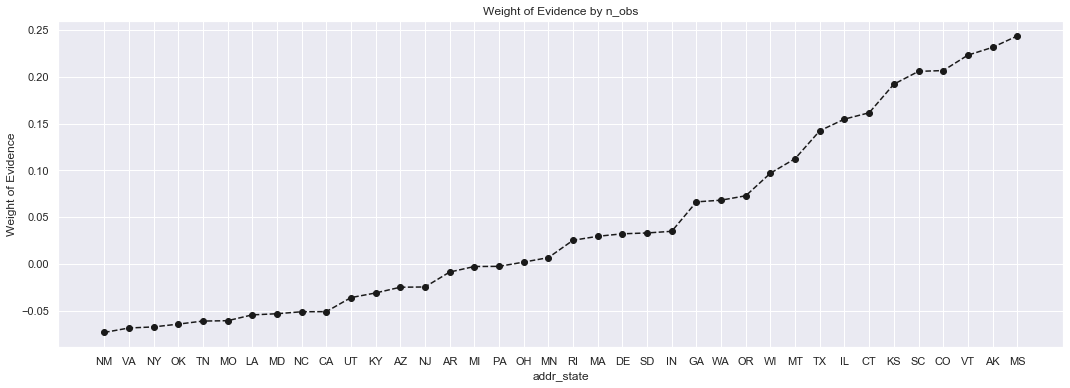

In [21]:
plot_by_woe(df_temp.iloc[6: -6, :])

In [22]:
#Adding North Dakota as its not in train set, but could be in test

if ['addr_state:ND'] in X_train.columns.values:
    pass
else:
    X_train['addr_state:ND'] = 0

#Grouping categories based on the amount of observations and WoE
#adding North Dakota here in the lowest WoE group
X_train['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([X_train['addr_state:ND'], X_train['addr_state:NE'],
                                                         X_train['addr_state:IA'], X_train['addr_state:NV'],
                                                         X_train['addr_state:FL'], X_train['addr_state:HI'],
                                                         X_train['addr_state:AL']])

X_train['addr_state:NM_VA'] = sum([X_train['addr_state:NM'], X_train['addr_state:VA']])

X_train['addr_state:OK_TN_MO_LA_MD_NC'] = sum([X_train['addr_state:OK'], X_train['addr_state:TN'],
                                              X_train['addr_state:MO'], X_train['addr_state:LA'],
                                              X_train['addr_state:MD'], X_train['addr_state:NC']])

X_train['addr_state:UT_KY_AZ_NJ'] = sum([X_train['addr_state:UT'], X_train['addr_state:KY'],
                                              X_train['addr_state:AZ'], X_train['addr_state:NJ']])

X_train['addr_state:AR_MI_PA_OH_MN'] = sum([X_train['addr_state:AR'], X_train['addr_state:MI'],
                                              X_train['addr_state:PA'], X_train['addr_state:OH'],
                                              X_train['addr_state:MN']])

X_train['addr_state:RI_MA_DE_SD_IN'] = sum([X_train['addr_state:RI'], X_train['addr_state:MA'],
                                              X_train['addr_state:DE'], X_train['addr_state:SD'],
                                              X_train['addr_state:IN']])

X_train['addr_state:GA_WA_OR'] = sum([X_train['addr_state:GA'], X_train['addr_state:WA'],
                                              X_train['addr_state:OR']])

X_train['addr_state:WI_MT'] = sum([X_train['addr_state:WI'], X_train['addr_state:MT']])

X_train['addr_state:IL_CT'] = sum([X_train['addr_state:IL'], X_train['addr_state:CT']])

X_train['addr_state:KS_SC_CO_VT_AK_MS'] = sum([X_train['addr_state:KS'], X_train['addr_state:SC'],
                                              X_train['addr_state:CO'], X_train['addr_state:VT'],
                                              X_train['addr_state:AK'], X_train['addr_state:MS']])

X_train['addr_state:WV_NH_WY_DC_ME_ID'] = sum([X_train['addr_state:WV'], X_train['addr_state:NH'],
                                              X_train['addr_state:WY'], X_train['addr_state:DC'],
                                              X_train['addr_state:ME'], X_train['addr_state:ID']])

In [23]:
X_train.columns

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       ...
       'addr_state:NM_VA', 'addr_state:OK_TN_MO_LA_MD_NC',
       'addr_state:UT_KY_AZ_NJ', 'addr_state:AR_MI_PA_OH_MN',
       'addr_state:RI_MA_DE_SD_IN', 'addr_state:GA_WA_OR', 'addr_state:WI_MT',
       'addr_state:IL_CT', 'addr_state:KS_SC_CO_VT_AK_MS',
       'addr_state:WV_NH_WY_DC_ME_ID'],
      dtype='object', length=220)

#### Verification status

In [24]:
df_temp = woe_discrete(X_train, 'verification_status', y_train)
df_temp

,n_obs,prop_good,prop_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
verification_status,,,,,,,,,
Verified,134414.0,0.872781,0.360332,117314.0,17100.0,0.353090,0.419344,-0.171969,0.020384
Source Verified,120030.0,0.895918,0.321772,107537.0,12493.0,0.323663,0.306366,0.054922,0.020384
Not Verified,118584.0,0.905679,0.317896,107399.0,11185.0,0.323248,0.274290,0.164232,0.020384


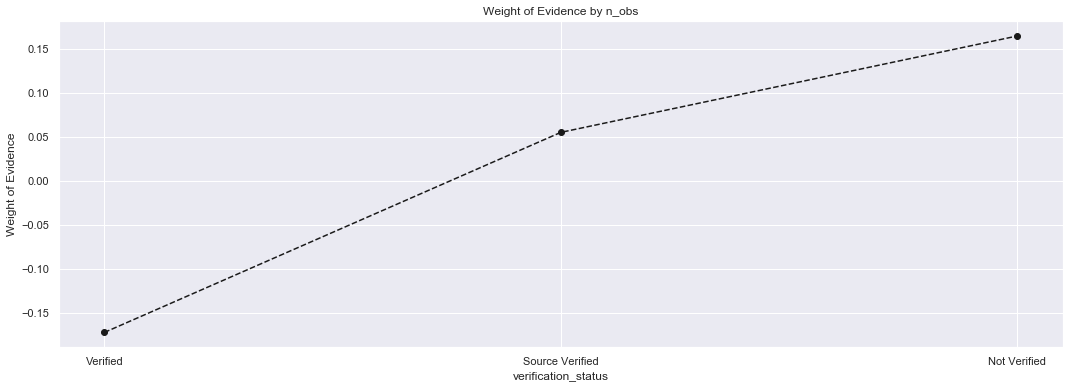

In [25]:
plot_by_woe(df_temp)
#keeping all 3 categories, all have different WoE and are numerous

#### Purpose

In [26]:
df_temp = woe_discrete(X_train, 'purpose', y_train)
df_temp

,n_obs,prop_good,prop_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
purpose,,,,,,,,,
small_business,5582.0,0.786098,0.014964,4388.0,1194.0,0.013207,0.029280,-0.796180,0.035418
educational,333.0,0.801802,0.000893,267.0,66.0,0.000804,0.001619,-0.700151,0.035418
moving,2392.0,0.839465,0.006412,2008.0,384.0,0.006044,0.009417,-0.443493,0.035418
house,1830.0,0.860109,0.004906,1574.0,256.0,0.004737,0.006278,-0.281547,0.035418
other,18884.0,0.862264,0.050624,16283.0,2601.0,0.049008,0.063784,-0.263519,0.035418
renewable_energy,281.0,0.864769,0.000753,243.0,38.0,0.000731,0.000932,-0.242270,0.035418
medical,3684.0,0.868350,0.009876,3199.0,485.0,0.009628,0.011894,-0.211300,0.035418
wedding,1887.0,0.881823,0.005059,1664.0,223.0,0.005008,0.005469,-0.087937,0.035418
vacation,1991.0,0.882471,0.005337,1757.0,234.0,0.005288,0.005738,-0.081703,0.035418


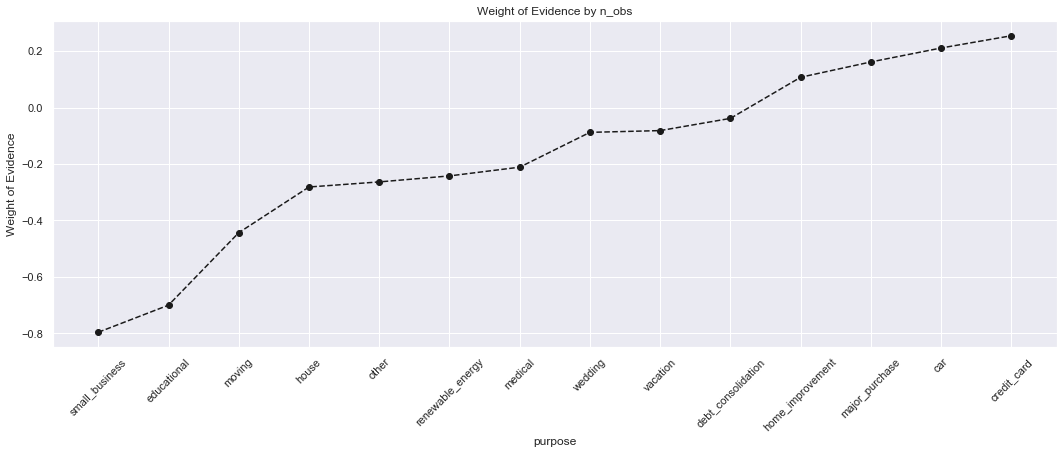

In [27]:
plot_by_woe(df_temp,45)

In [28]:
# combining 'educational', 'small_business', 'wedding', 'renewable_energy', 'moving', 'house' in one category:
# comining 'other', 'medical', 'vacation'
# combining 'major_purchase', 'car', 'home_improvement' 
# 'debt_consolidtion' in a separate category.
# 'credit_card' in a separate category.

X_train['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([X_train['purpose:educational'], X_train['purpose:small_business'],
                                                                 X_train['purpose:wedding'], X_train['purpose:renewable_energy'],
                                                                 X_train['purpose:moving'], X_train['purpose:house']])
X_train['purpose:oth__med__vacation'] = sum([X_train['purpose:other'], X_train['purpose:medical'],
                                             X_train['purpose:vacation']])
X_train['purpose:major_purch__car__home_impr'] = sum([X_train['purpose:major_purchase'], X_train['purpose:car'],
                                                        X_train['purpose:home_improvement']])

#### Initial list status

In [29]:
df_temp = woe_discrete(X_train, 'initial_list_status', y_train)
df_temp
#keeping both

,n_obs,prop_good,prop_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
initial_list_status,,,,,,,,,
f,242514.0,0.879694,0.650123,213338.0,29176.0,0.642101,0.715484,-0.108214,0.02478
w,130514.0,0.911105,0.349877,118912.0,11602.0,0.357899,0.284516,0.229461,0.02478


In [30]:
#adjusting function for continous variable
def woe_ordered_continuous(df, discrete_var_name, y):
    df = pd.concat([df[discrete_var_name], y], axis = 1)
    pivot = df.pivot_table(index = discrete_var_name, values= "good_bad", aggfunc = ("count", "mean")).rename(
                                                                columns={"count":"n_obs","mean":"prop_good"})
    pivot["prop_obs"] = pivot["n_obs"] / pivot["n_obs"].sum() #how common is each class
    pivot["n_good"] = pivot['prop_good'] * pivot['n_obs'] #counting number of good borrowers in each group
    pivot['n_bad'] = (1 - pivot['prop_good']) * pivot['n_obs'] #number of bad borrowers
    
    #percentage of good borrowers in the group compared to all good
    pivot['prop_n_good'] = pivot['n_good'] / pivot['n_good'].sum() 
    pivot['prop_n_bad'] = pivot['n_bad'] / pivot['n_bad'].sum()

    #calculating the weight of evidence using natural log
    pivot['WoE'] = np.log(pivot['prop_n_good'] / pivot['prop_n_bad'])
    #pivot = pivot.sort_values(['WoE'])

    #calculating information value of the factor
    pivot['IV'] = (pivot['prop_n_good'] - pivot['prop_n_bad']) * pivot['WoE']
    pivot['IV'] = pivot['IV'].sum() #is the same for all members of the column
    return pivot

####  Term (int)

In [31]:
df_temp = woe_ordered_continuous(X_train, 'term_int', y_train)
df_temp

,n_obs,prop_good,prop_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
term_int,,,,,,,,,
36,270419.0,0.902995,0.724929,244187.0,26232.0,0.73495,0.643288,0.133209,0.039434
60,102609.0,0.858239,0.275071,88063.0,14546.0,0.26505,0.356712,-0.297009,0.039434


In [32]:
#keeping both
X_train['term:36'] = np.where((X_train['term_int'] == 36), 1, 0)
X_train['term:60'] = np.where((X_train['term_int'] == 60), 1, 0)

#### Lenght of employment

In [33]:
df_temp = woe_ordered_continuous(X_train, 'emp_length_int', y_train)
df_temp

,n_obs,prop_good,prop_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
emp_length_int,,,,,,,,,
0.0,28912.0,0.881157,0.081163,25476.0,3436.0,0.080200,0.089101,-0.105250,0.004847
1.0,23654.0,0.886996,0.066403,20981.0,2673.0,0.066049,0.069315,-0.048263,0.004847
2.0,33078.0,0.890955,0.092858,29471.0,3607.0,0.092776,0.093535,-0.008149,0.004847
3.0,29205.0,0.890772,0.081986,26015.0,3190.0,0.081897,0.082722,-0.010027,0.004847
4.0,22468.0,0.890644,0.063073,20011.0,2457.0,0.062996,0.063714,-0.011338,0.004847
5.0,24602.0,0.884725,0.069064,21766.0,2836.0,0.068520,0.073542,-0.070724,0.004847
6.0,20887.0,0.883899,0.058635,18462.0,2425.0,0.058119,0.062884,-0.078796,0.004847
7.0,21049.0,0.887453,0.059090,18680.0,2369.0,0.058806,0.061432,-0.043693,0.004847
8.0,17853.0,0.889878,0.050118,15887.0,1966.0,0.050013,0.050982,-0.019179,0.004847


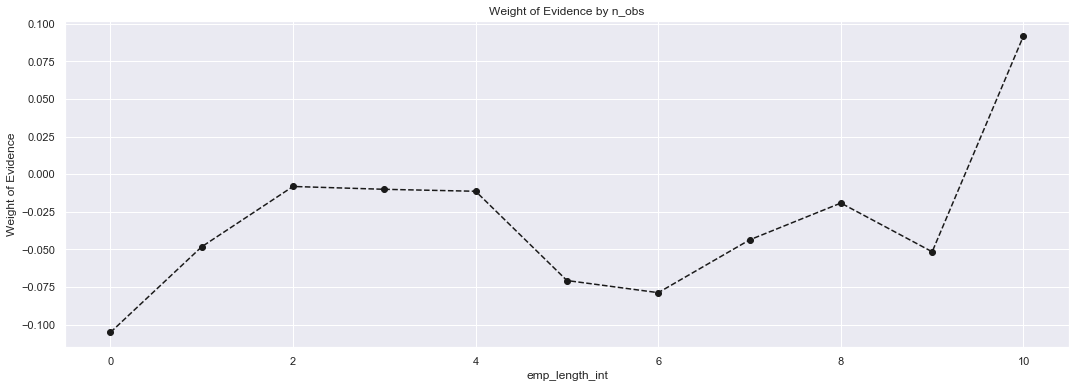

In [34]:
plot_by_woe(df_temp)

In [35]:
X_train['emp_length:0'] = np.where(X_train['emp_length_int'].isin([0]), 1, 0)
X_train['emp_length:1'] = np.where(X_train['emp_length_int'].isin([1]), 1, 0)
X_train['emp_length:2-4'] = np.where(X_train['emp_length_int'].isin(range(2, 5)), 1, 0)#inclusive of lower value, exc higher
X_train['emp_length:5-6'] = np.where(X_train['emp_length_int'].isin(range(5, 7)), 1, 0)
X_train['emp_length:7-9'] = np.where(X_train['emp_length_int'].isin(range(7, 10)), 1, 0)
X_train['emp_length:10'] = np.where(X_train['emp_length_int'].isin([10]), 1, 0)

#### Months since issue

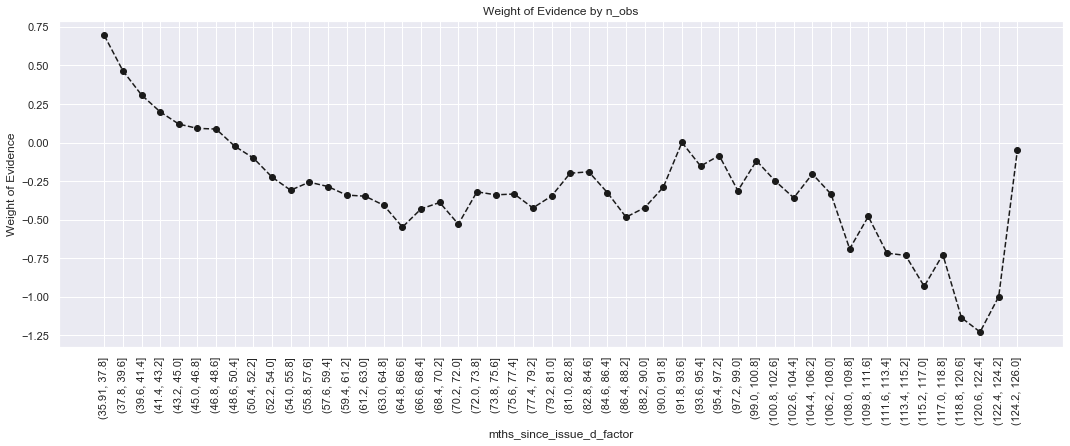

In [36]:
#Fine classing
X_train['mths_since_issue_d_factor'] = pd.cut(X_train['mths_since_issue_d'], 50)
df_temp = woe_ordered_continuous(X_train, 'mths_since_issue_d_factor', y_train)
df_temp.index = df_temp.index.astype(str) #cant plot x as an interval
plot_by_woe(df_temp, 90)

In [37]:
#classing
X_train['mths_since_issue_d:<38'] = np.where(X_train['mths_since_issue_d'].isin(range(38)), 1, 0)
X_train['mths_since_issue_d:38-39'] = np.where(X_train['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
X_train['mths_since_issue_d:40-41'] = np.where(X_train['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
X_train['mths_since_issue_d:42-48'] = np.where(X_train['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
X_train['mths_since_issue_d:49-52'] = np.where(X_train['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
X_train['mths_since_issue_d:53-64'] = np.where(X_train['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
X_train['mths_since_issue_d:65-84'] = np.where(X_train['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
X_train['mths_since_issue_d:>84'] = np.where(X_train['mths_since_issue_d'].isin(range(85, int(X_train['mths_since_issue_d'].max()))), 1, 0)

#### Interest rate

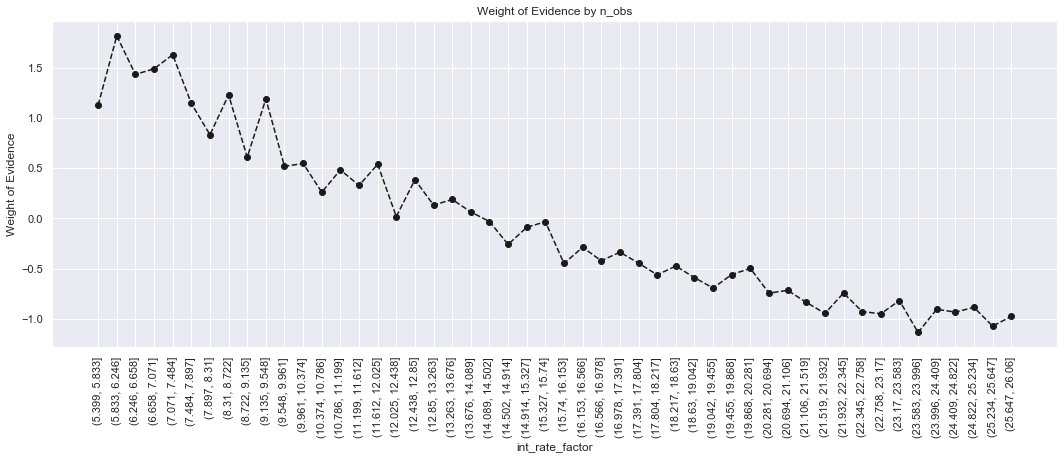

In [38]:
X_train['int_rate_factor'] = pd.cut(X_train['int_rate'], 50)
df_temp = woe_ordered_continuous(X_train, 'int_rate_factor', y_train)
df_temp.index = df_temp.index.astype(str) #cant plot x as an interval
plot_by_woe(df_temp, 90)

In [39]:
X_train['int_rate:<9.548'] = np.where((X_train['int_rate'] <= 9.548), 1, 0)
X_train['int_rate:9.548-12.025'] = np.where((X_train['int_rate'] > 9.548) & (X_train['int_rate'] <= 12.025), 1, 0)
X_train['int_rate:12.025-15.74'] = np.where((X_train['int_rate'] > 12.025) & (X_train['int_rate'] <= 15.74), 1, 0)
X_train['int_rate:15.74-20.281'] = np.where((X_train['int_rate'] > 15.74) & (X_train['int_rate'] <= 20.281), 1, 0)
X_train['int_rate:>20.281'] = np.where((X_train['int_rate'] > 20.281), 1, 0)

#### Funded amount

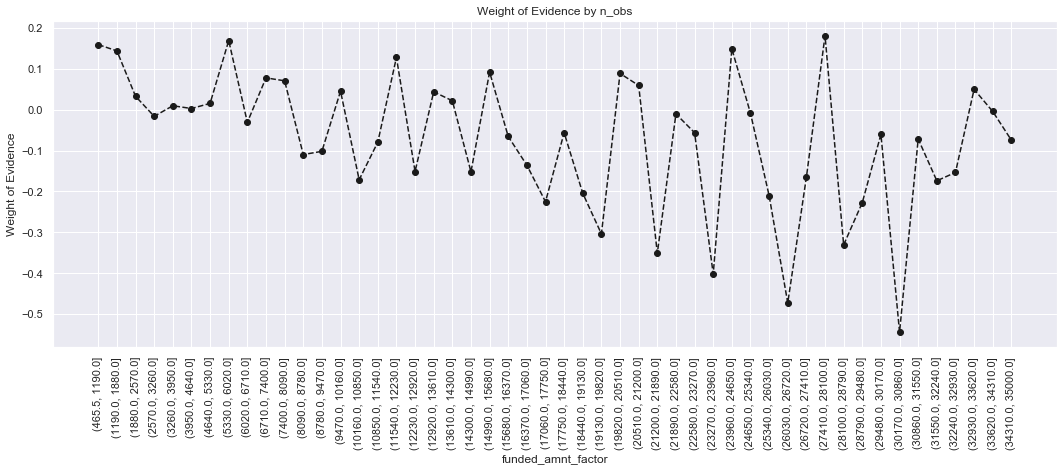

In [40]:
X_train['funded_amnt_factor'] = pd.cut(X_train['funded_amnt'], 50)
df_temp = woe_ordered_continuous(X_train, 'funded_amnt_factor', y_train)
df_temp.index = df_temp.index.astype(str) #cant plot x as an interval
plot_by_woe(df_temp, 90)
#due to high variation and almost horizontal trend, I will not use this variable

#### Months since earliest credit line

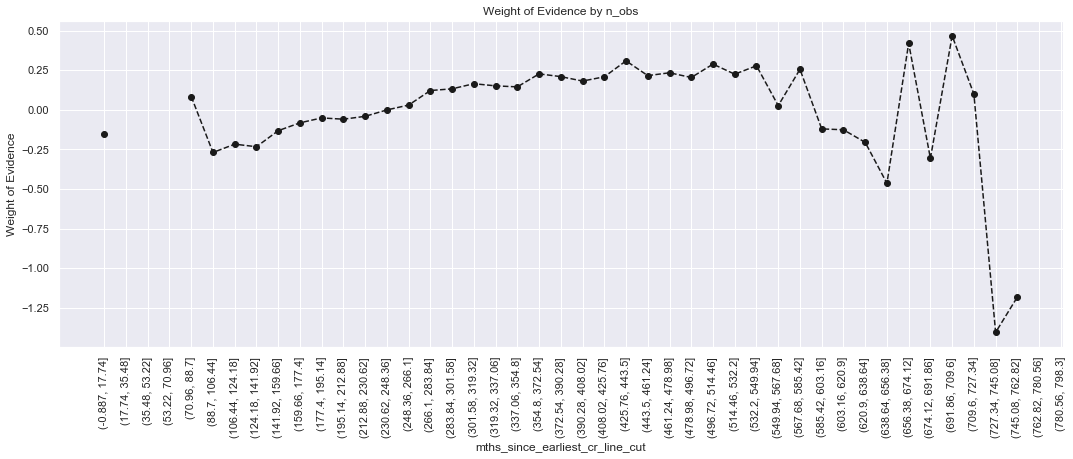

In [41]:
X_train['mths_since_earliest_cr_line_cut'] = pd.cut(X_train['mths_since_earliest_cr_line'], 50)
df_temp = woe_ordered_continuous(X_train, 'mths_since_earliest_cr_line_cut', y_train)
df_temp.index = df_temp.index.astype(str) #cant plot x as an interval
plot_by_woe(df_temp, 90)

In [42]:
df_temp

,n_obs,prop_good,prop_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
mths_since_earliest_cr_line_cut,,,,,,,,,
"(-0.887, 17.74]",24.0,0.875000,0.000064,21.0,3.0,0.000063,0.000074,-0.151835,inf
"(17.74, 35.48]",0.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
"(35.48, 53.22]",0.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
"(53.22, 70.96]",0.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
"(70.96, 88.7]",1815.0,0.898623,0.004866,1631.0,184.0,0.004909,0.004512,0.084268,inf
"(88.7, 106.44]",3873.0,0.861606,0.010383,3337.0,536.0,0.010044,0.013144,-0.269052,inf
"(106.44, 124.18]",10048.0,0.867735,0.026936,8719.0,1329.0,0.026242,0.032591,-0.216667,inf
"(124.18, 141.92]",16745.0,0.865870,0.044889,14499.0,2246.0,0.043639,0.055079,-0.232816,inf
"(141.92, 159.66]",21889.0,0.877199,0.058679,19201.0,2688.0,0.057791,0.065918,-0.131580,inf


In [43]:
X_train['mths_since_earliest_cr_line:<140'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
X_train['mths_since_earliest_cr_line:141-177'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(141,177)), 1, 0)
X_train['mths_since_earliest_cr_line:178-230'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(178,230)), 1, 0)
X_train['mths_since_earliest_cr_line:231-266'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(231,266)), 1, 0)
X_train['mths_since_earliest_cr_line:267-354'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(267,354)), 1, 0)
X_train['mths_since_earliest_cr_line:355-390'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(355,390)), 1, 0)
X_train['mths_since_earliest_cr_line:>391'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(391,int(X_train["mths_since_earliest_cr_line"].max()))), 1, 0)

#### Installments

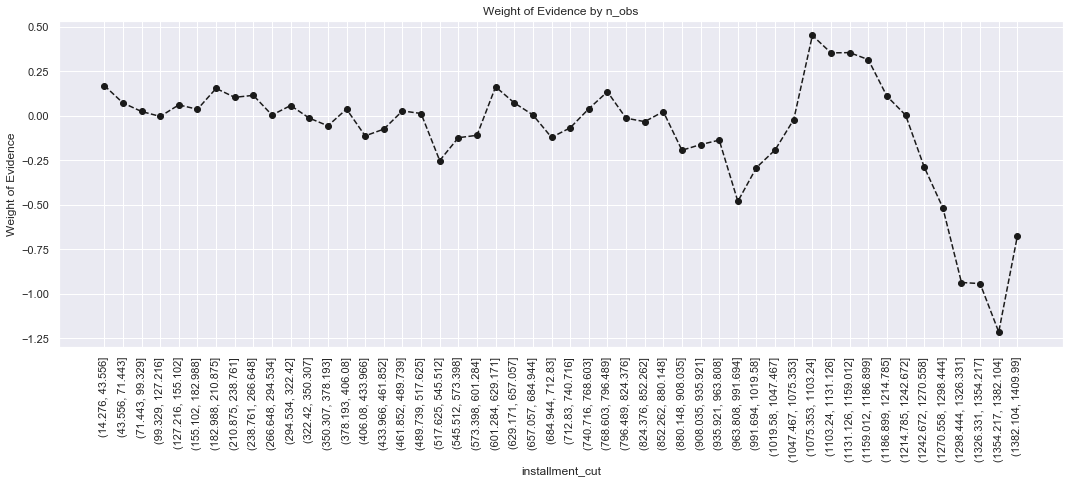

In [44]:
X_train['installment_cut'] = pd.cut(X_train['installment'], 50)
df_temp = woe_ordered_continuous(X_train, 'installment_cut', y_train)
df_temp.index = df_temp.index.astype(str) #cant plot x as an interval
plot_by_woe(df_temp, 90)
#not using due to horizontal trend, and final categories have low n

#### Deliquency 2 years 

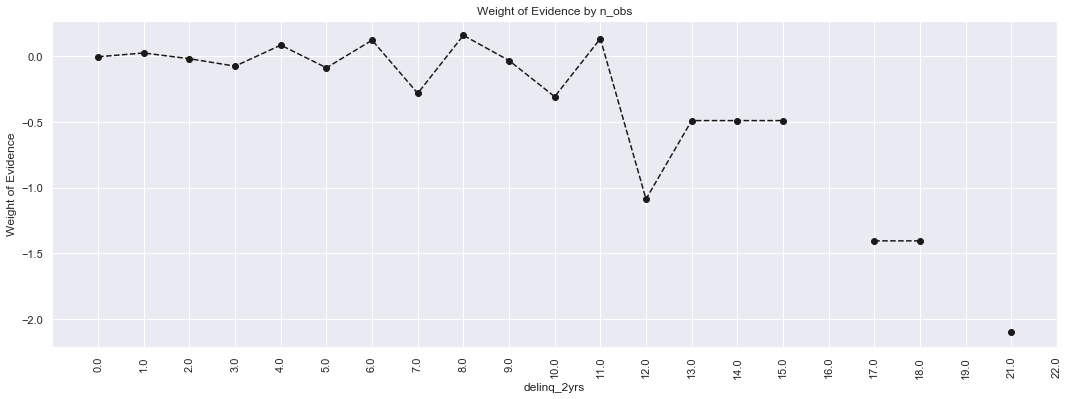

In [45]:
X_train['delinq_2yrs_cut'] = pd.cut(X_train['delinq_2yrs'], 50) # not working well when cut.
df_temp = woe_ordered_continuous(X_train, 'delinq_2yrs', y_train)
df_temp.index = df_temp.index.astype(str) #cant plot x as an interval
plot_by_woe(df_temp, 90)

In [46]:
X_train['delinq_2yrs:0'] = np.where((X_train['delinq_2yrs'] == 0), 1, 0)
X_train['delinq_2yrs:1-3'] = np.where((X_train['delinq_2yrs'] >= 1) & (X_train['delinq_2yrs'] <= 3), 1, 0)
X_train['delinq_2yrs:>=4'] = np.where((X_train['delinq_2yrs'] >= 9), 1, 0)

#### inq_last_6mths

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


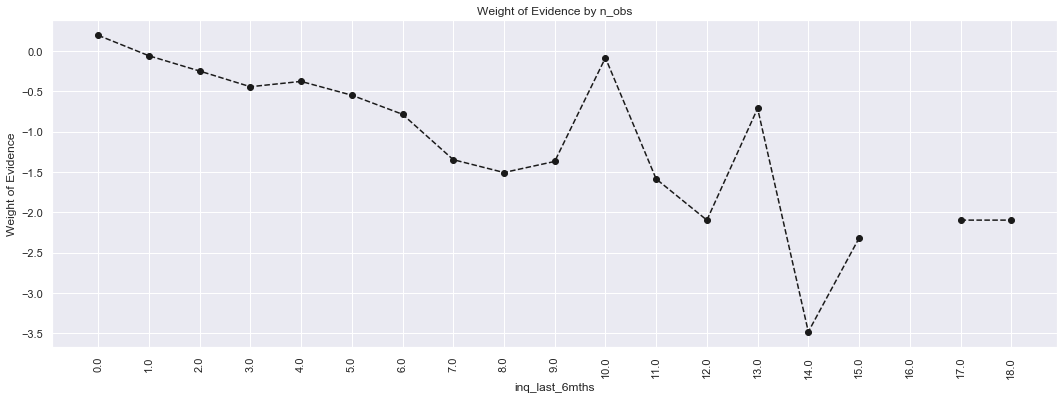

In [47]:
X_train['inq_last_6mths_cut'] = pd.cut(X_train['inq_last_6mths'], 50) 
df_temp = woe_ordered_continuous(X_train, 'inq_last_6mths', y_train)
df_temp.index = df_temp.index.astype(str) #cant plot x as an interval
plot_by_woe(df_temp, 90)

In [48]:
#df_temp
X_train['inq_last_6mths:0'] = np.where((X_train['inq_last_6mths'] == 0), 1, 0)
X_train['inq_last_6mths:1-2'] = np.where((X_train['inq_last_6mths'] >= 1) & (X_train['inq_last_6mths'] <= 2), 1, 0)
X_train['inq_last_6mths:3-4'] = np.where((X_train['inq_last_6mths'] >= 3) & (X_train['inq_last_6mths'] <= 4), 1, 0)
X_train['inq_last_6mths:>4'] = np.where((X_train['inq_last_6mths'] > 4), 1, 0)

#### Open account

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


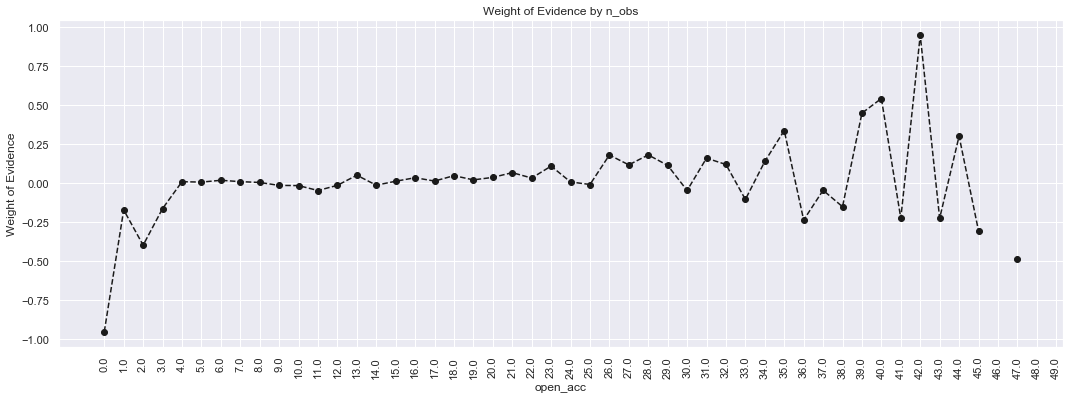

In [49]:
df_temp = woe_ordered_continuous(X_train, 'open_acc', y_train)
df_temp.index = df_temp.index.astype(str) #cant plot x as an interval
plot_by_woe(df_temp, 90)

In [50]:
X_train['open_acc:0'] = np.where((X_train['open_acc'] == 0), 1, 0)
X_train['open_acc:1-3'] = np.where((X_train['open_acc'] >= 1) & (X_train['open_acc'] <= 3), 1, 0)
X_train['open_acc:4-12'] = np.where((X_train['open_acc'] >= 4) & (X_train['open_acc'] <= 12), 1, 0)
X_train['open_acc:13-17'] = np.where((X_train['open_acc'] >= 13) & (X_train['open_acc'] <= 17), 1, 0)
X_train['open_acc:18-22'] = np.where((X_train['open_acc'] >= 18) & (X_train['open_acc'] <= 22), 1, 0)
X_train['open_acc:23-25'] = np.where((X_train['open_acc'] >= 23) & (X_train['open_acc'] <= 25), 1, 0)
X_train['open_acc:26-30'] = np.where((X_train['open_acc'] >= 26) & (X_train['open_acc'] <= 30), 1, 0)
X_train['open_acc:>=31'] = np.where((X_train['open_acc'] >= 31), 1, 0)

#### pub_rec

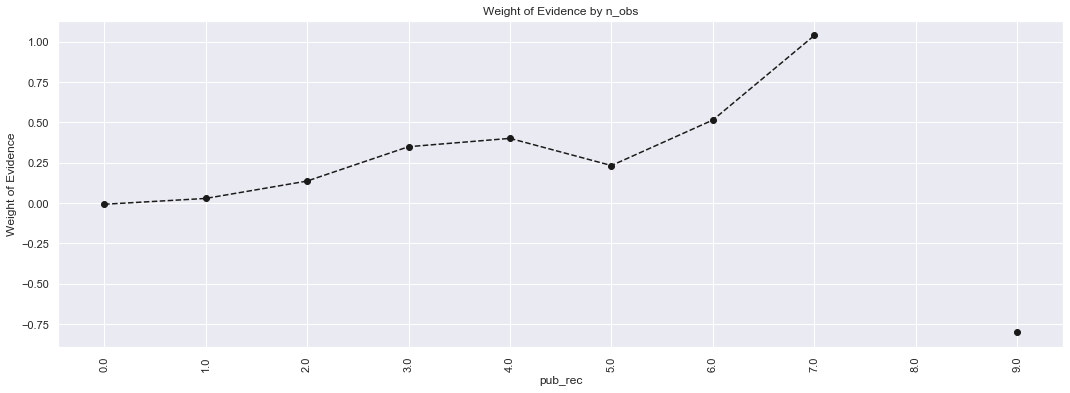

In [51]:
df_temp = woe_ordered_continuous(X_train, 'pub_rec', y_train)
df_temp.index = df_temp.index.astype(str) #cant plot x as an interval
plot_by_woe(df_temp, 90)

In [52]:
df_temp

,n_obs,prop_good,prop_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
pub_rec,,,,,,,,,
0.0,323999.0,0.889941,0.868565,288340.0,35659.0,0.867840,0.874467,-0.007606,inf
1.0,42381.0,0.893419,0.113613,37864.0,4517.0,0.113962,0.110771,0.028408,inf
2.0,4527.0,0.903247,0.012136,4089.0,438.0,0.012307,0.010741,0.136092,inf
3.0,1280.0,0.920312,0.003431,1178.0,102.0,0.003546,0.002501,0.348856,inf
4.0,408.0,0.924020,0.001094,377.0,31.0,0.001135,0.000760,0.400513,inf
5.0,203.0,0.911330,0.000544,185.0,18.0,0.000557,0.000441,0.232239,inf
6.0,117.0,0.931624,0.000314,109.0,8.0,0.000328,0.000196,0.514161,inf
7.0,48.0,0.958333,0.000129,46.0,2.0,0.000138,0.000049,1.037749,inf
8.0,24.0,1.000000,0.000064,24.0,0.0,0.000072,0.000000,inf,inf


In [53]:
X_train['pub_rec:0-2'] = np.where((X_train['pub_rec'] >= 0) & (X_train['pub_rec'] <= 2), 1, 0)
X_train['pub_rec:3-4'] = np.where((X_train['pub_rec'] >= 3) & (X_train['pub_rec'] <= 4), 1, 0)
X_train['pub_rec:>=5'] = np.where((X_train['pub_rec'] >= 5), 1, 0)

#### Total accounts

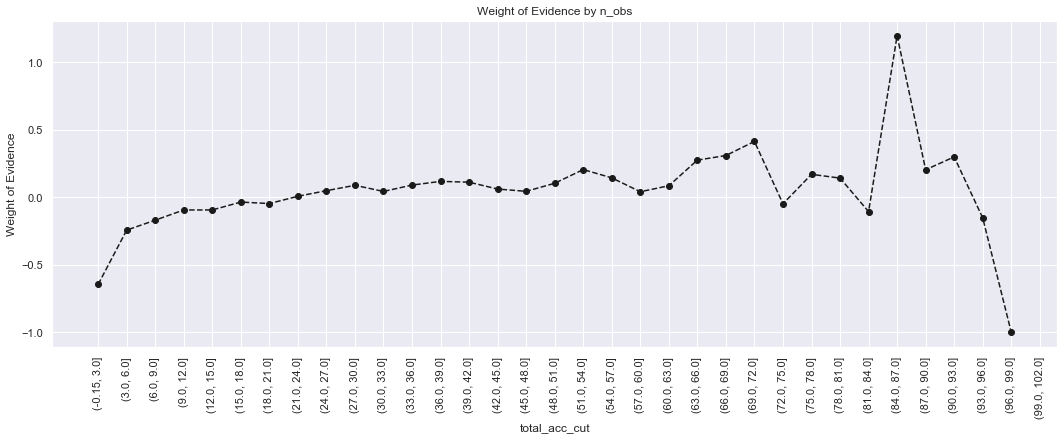

In [54]:
X_train['total_acc_cut'] = pd.cut(X_train['total_acc'], 50) # not working well when cut.
df_temp = woe_ordered_continuous(X_train, 'total_acc_cut', y_train)
df_temp.index = df_temp.index.astype(str) #cant plot x as an interval
plot_by_woe(df_temp, 90)

In [55]:
X_train['total_acc:<=27'] = np.where((X_train['total_acc'] <= 27), 1, 0)
X_train['total_acc:28-51'] = np.where((X_train['total_acc'] >= 28) & (X_train['total_acc'] <= 51), 1, 0)
X_train['total_acc:>=52'] = np.where((X_train['total_acc'] >= 52), 1, 0)

#### Accounts now deliquent

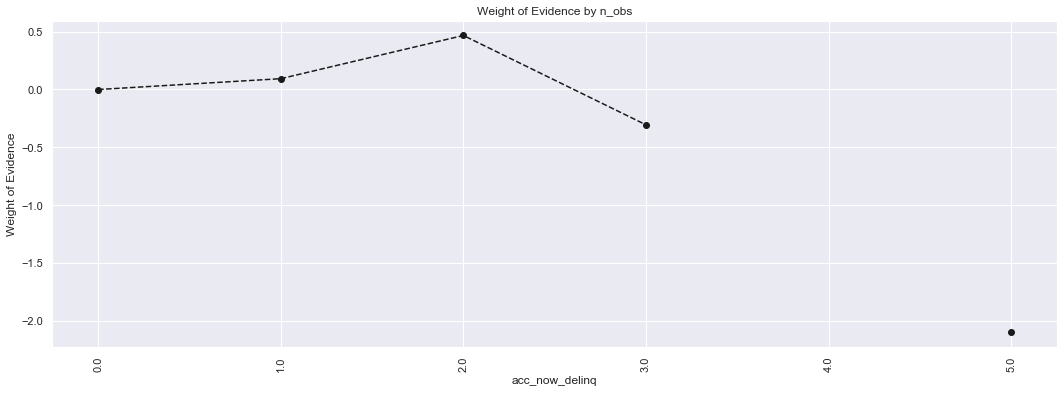

In [56]:
df_temp = woe_ordered_continuous(X_train, 'acc_now_delinq', y_train)
df_temp.index = df_temp.index.astype(str) #cant plot x as an interval
plot_by_woe(df_temp, 90)

In [57]:
X_train['acc_now_delinq:0'] = np.where((X_train['acc_now_delinq'] == 0), 1, 0)
X_train['acc_now_delinq:>=1'] = np.where((X_train['acc_now_delinq'] >= 1), 1, 0)

#### pub_rec

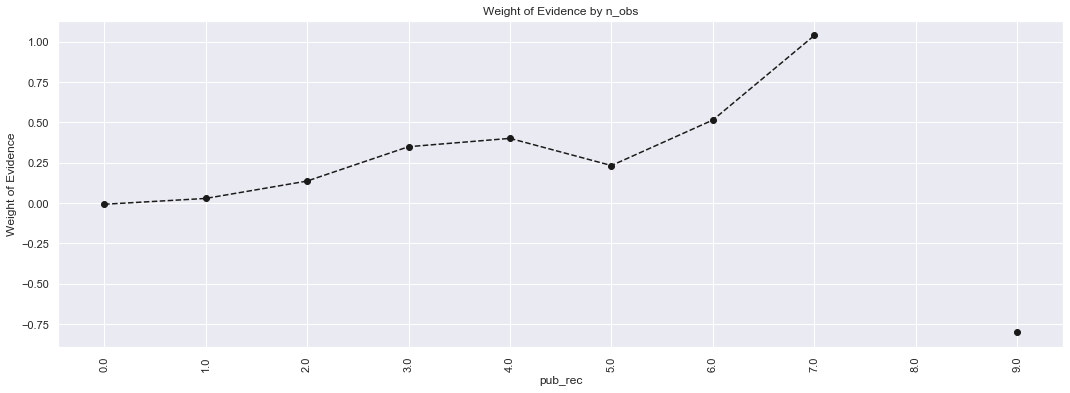

In [58]:
df_temp = woe_ordered_continuous(X_train, 'pub_rec', y_train)
df_temp.index = df_temp.index.astype(str) #cant plot x as an interval
plot_by_woe(df_temp, 90)

In [59]:
X_train['pub_rec:0-2'] = np.where((X_train['pub_rec'] >= 0) & (X_train['pub_rec'] <= 2), 1, 0)
X_train['pub_rec:3-4'] = np.where((X_train['pub_rec'] >= 3) & (X_train['pub_rec'] <= 4), 1, 0)
X_train['pub_rec:>=5'] = np.where((X_train['pub_rec'] >= 5), 1, 0)

#### total_rev_hi_lim_factor

In [60]:
X_train['total_rev_hi_lim_factor'] = pd.cut(X_train['total_rev_hi_lim'], 2000)
df_temp = woe_ordered_continuous(X_train, 'total_rev_hi_lim_factor', y_train)
df_temp

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


,n_obs,prop_good,prop_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
total_rev_hi_lim_factor,,,,,,,,,
"(-9999.999, 5000.0]",19417.0,0.866457,0.052052,16824.0,2593.0,0.050637,0.063588,-0.227754,inf
"(5000.0, 9999.999]",52655.0,0.876194,0.141156,46136.0,6519.0,0.138859,0.159866,-0.140872,inf
"(9999.999, 14999.998]",59570.0,0.880376,0.159693,52444.0,7126.0,0.157845,0.174751,-0.101749,inf
"(14999.998, 19999.998]",51455.0,0.877582,0.137939,45156.0,6299.0,0.135910,0.154471,-0.128013,inf
"(19999.998, 24999.997]",41582.0,0.885792,0.111472,36833.0,4749.0,0.110859,0.116460,-0.049285,inf
"(24999.997, 29999.997]",32093.0,0.889415,0.086034,28544.0,3549.0,0.085911,0.087032,-0.012964,inf
"(29999.997, 34999.996]",24516.0,0.894885,0.065722,21939.0,2577.0,0.066032,0.063196,0.043895,inf
"(34999.996, 39999.996]",19767.0,0.903374,0.052991,17857.0,1910.0,0.053746,0.046839,0.137547,inf
"(39999.996, 44999.996]",14719.0,0.914396,0.039458,13459.0,1260.0,0.040509,0.030899,0.270791,inf


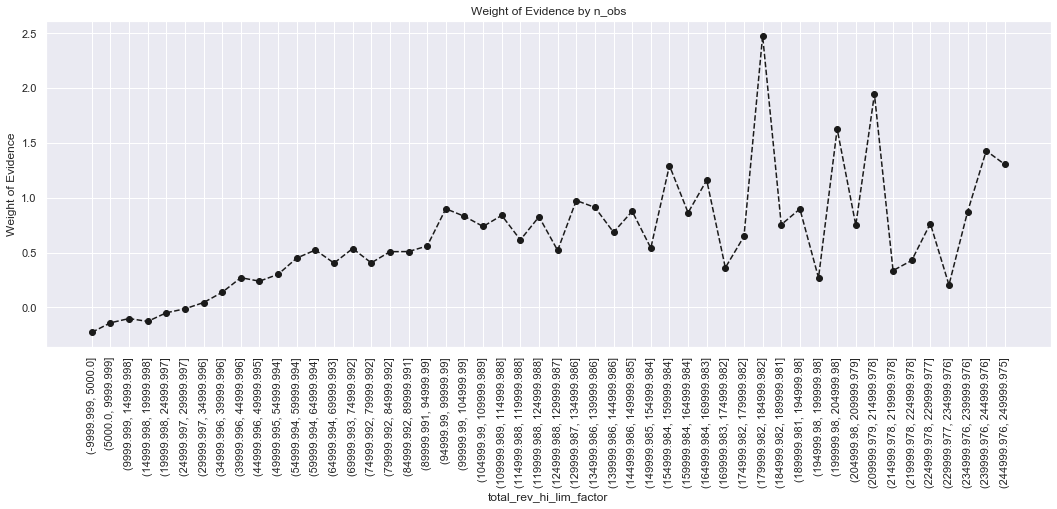

In [61]:
df_temp.index = df_temp.index.astype(str)
plot_by_woe(df_temp.iloc[: 50, : ], 90)

In [62]:
X_train['total_rev_hi_lim:<=5K'] = np.where((X_train['total_rev_hi_lim'] <= 5000), 1, 0)
X_train['total_rev_hi_lim:5K-10K'] = np.where((X_train['total_rev_hi_lim'] > 5000) & (X_train['total_rev_hi_lim'] <= 10000), 1, 0)
X_train['total_rev_hi_lim:10K-20K'] = np.where((X_train['total_rev_hi_lim'] > 10000) & (X_train['total_rev_hi_lim'] <= 20000), 1, 0)
X_train['total_rev_hi_lim:20K-30K'] = np.where((X_train['total_rev_hi_lim'] > 20000) & (X_train['total_rev_hi_lim'] <= 30000), 1, 0)
X_train['total_rev_hi_lim:30K-40K'] = np.where((X_train['total_rev_hi_lim'] > 30000) & (X_train['total_rev_hi_lim'] <= 40000), 1, 0)
X_train['total_rev_hi_lim:40K-55K'] = np.where((X_train['total_rev_hi_lim'] > 40000) & (X_train['total_rev_hi_lim'] <= 55000), 1, 0)
X_train['total_rev_hi_lim:55K-95K'] = np.where((X_train['total_rev_hi_lim'] > 55000) & (X_train['total_rev_hi_lim'] <= 95000), 1, 0)
X_train['total_rev_hi_lim:>95K'] = np.where((X_train['total_rev_hi_lim'] > 95000), 1, 0)

#### Anual income

In [63]:
X_train['annual_inc_factor'] = pd.cut(X_train['annual_inc'], 100)
df_temp = woe_ordered_continuous(X_train, 'annual_inc_factor', y_train)
df_temp

,n_obs,prop_good,prop_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
annual_inc_factor,,,,,,,,,
"(-5243.882, 73294.82]",231445.0,0.875901,0.620449,202723.0,28722.0,0.610152,0.704350,-0.143568,inf
"(73294.82, 144693.64]",120459.0,0.912900,0.322922,109967.0,10492.0,0.330977,0.257296,0.251822,inf
"(144693.64, 216092.46]",15885.0,0.925087,0.042584,14695.0,1190.0,0.044229,0.029182,0.415809,inf
"(216092.46, 287491.28]",3119.0,0.927220,0.008361,2892.0,227.0,0.008704,0.005567,0.447009,inf
"(287491.28, 358890.1]",1117.0,0.929275,0.002994,1038.0,79.0,0.003124,0.001937,0.477858,inf
"(358890.1, 430288.92]",408.0,0.933824,0.001094,381.0,27.0,0.001147,0.000662,0.549218,inf
"(430288.92, 501687.74]",245.0,0.946939,0.000657,232.0,13.0,0.000698,0.000319,0.784043,inf
"(501687.74, 573086.56]",87.0,0.919540,0.000233,80.0,7.0,0.000241,0.000172,0.338372,inf
"(573086.56, 644485.38]",61.0,0.868852,0.000164,53.0,8.0,0.000160,0.000196,-0.206895,inf


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


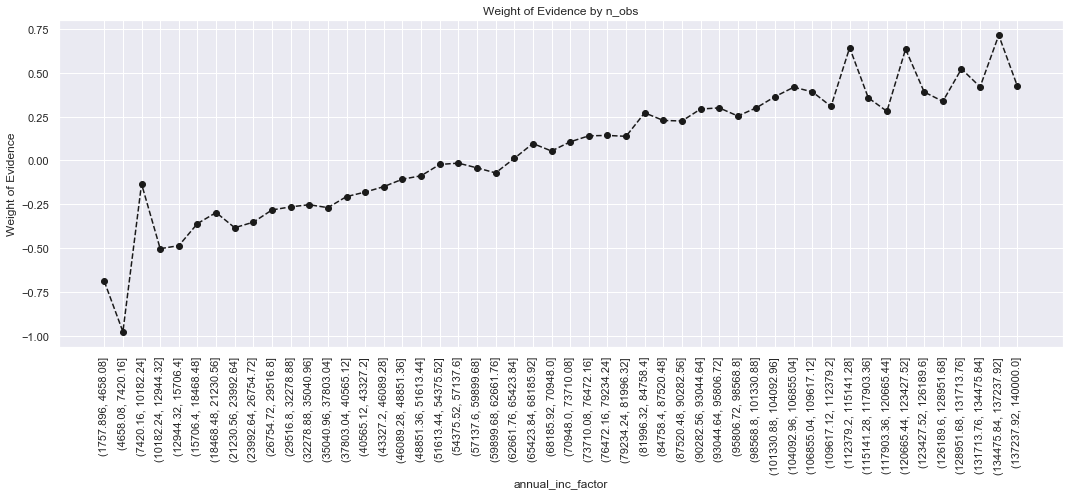

In [64]:
#cutting 140k + into separate category and looking at the rest
X_train_temp = X_train.loc[X_train['annual_inc'] <= 140000, : ] 
X_train_temp['annual_inc_factor'] = pd.cut(X_train_temp['annual_inc'], 50)
df_temp = woe_ordered_continuous(X_train_temp, 'annual_inc_factor', y_train[X_train_temp.index])
df_temp.index = df_temp.index.astype(str)
plot_by_woe(df_temp,90)

In [65]:
X_train['annual_inc:<20K'] = np.where((X_train['annual_inc'] <= 20000), 1, 0)
X_train['annual_inc:20K-30K'] = np.where((X_train['annual_inc'] > 20000) & (X_train['annual_inc'] <= 30000), 1, 0)
X_train['annual_inc:30K-40K'] = np.where((X_train['annual_inc'] > 30000) & (X_train['annual_inc'] <= 40000), 1, 0)
X_train['annual_inc:40K-50K'] = np.where((X_train['annual_inc'] > 40000) & (X_train['annual_inc'] <= 50000), 1, 0)
X_train['annual_inc:50K-60K'] = np.where((X_train['annual_inc'] > 50000) & (X_train['annual_inc'] <= 60000), 1, 0)
X_train['annual_inc:60K-70K'] = np.where((X_train['annual_inc'] > 60000) & (X_train['annual_inc'] <= 70000), 1, 0)
X_train['annual_inc:70K-80K'] = np.where((X_train['annual_inc'] > 70000) & (X_train['annual_inc'] <= 80000), 1, 0)
X_train['annual_inc:80K-90K'] = np.where((X_train['annual_inc'] > 80000) & (X_train['annual_inc'] <= 90000), 1, 0)
X_train['annual_inc:90K-100K'] = np.where((X_train['annual_inc'] > 90000) & (X_train['annual_inc'] <= 100000), 1, 0)
X_train['annual_inc:100K-120K'] = np.where((X_train['annual_inc'] > 100000) & (X_train['annual_inc'] <= 120000), 1, 0)
X_train['annual_inc:120K-140K'] = np.where((X_train['annual_inc'] > 120000) & (X_train['annual_inc'] <= 140000), 1, 0)
X_train['annual_inc:>140K'] = np.where((X_train['annual_inc'] > 140000), 1, 0)

#### months since last deliquency

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


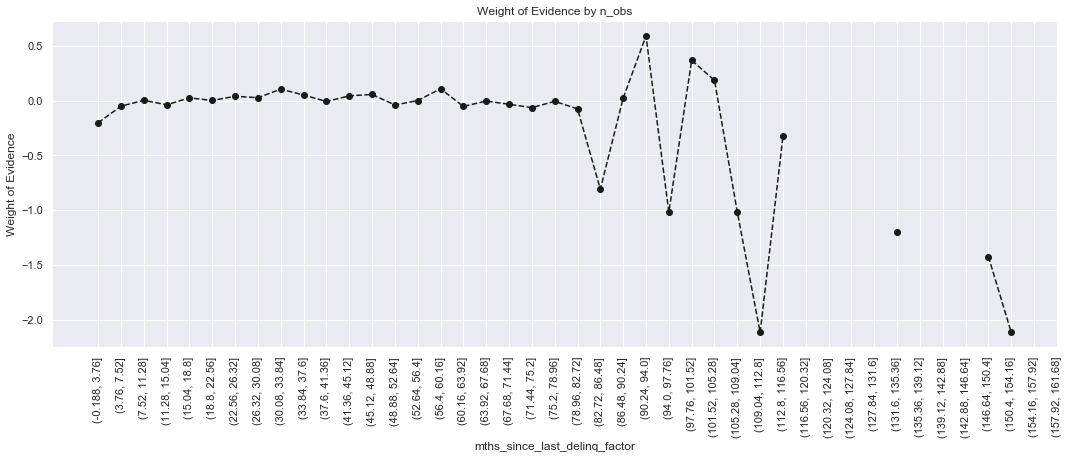

In [66]:
X_train_temp = X_train[pd.notnull(X_train['mths_since_last_delinq'])]
X_train_temp['mths_since_last_delinq_factor'] = pd.cut(X_train_temp['mths_since_last_delinq'], 50)
df_temp = woe_ordered_continuous(X_train_temp, 'mths_since_last_delinq_factor', y_train[X_train_temp.index])
df_temp.index = df_temp.index.astype(str)
plot_by_woe(df_temp,90)

In [67]:
X_train['mths_since_last_delinq:Missing'] = np.where((X_train['mths_since_last_delinq'].isnull()), 1, 0)
X_train['mths_since_last_delinq:0-3'] = np.where((X_train['mths_since_last_delinq'] >= 0) & (X_train['mths_since_last_delinq'] <= 3), 1, 0)
X_train['mths_since_last_delinq:4-30'] = np.where((X_train['mths_since_last_delinq'] >= 4) & (X_train['mths_since_last_delinq'] <= 30), 1, 0)
X_train['mths_since_last_delinq:31-56'] = np.where((X_train['mths_since_last_delinq'] >= 31) & (X_train['mths_since_last_delinq'] <= 56), 1, 0)
X_train['mths_since_last_delinq:>=57'] = np.where((X_train['mths_since_last_delinq'] >= 57), 1, 0)

#### preprocessing the test dataset 

In [68]:
#home ownership
X_test['home_ownership:RENT_OTHER_NONE_ANY'] = sum([X_test['home_ownership:RENT'], X_test['home_ownership:OTHER'],
                                                      X_test['home_ownership:NONE'],X_test['home_ownership:ANY']])

#state
if ['addr_state:ND'] in X_test.columns.values:
    pass
else:
    X_test['addr_state:ND'] = 0

X_test['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([X_test['addr_state:ND'], X_test['addr_state:NE'],
                                                         X_test['addr_state:IA'], X_test['addr_state:NV'],
                                                         X_test['addr_state:FL'], X_test['addr_state:HI'],
                                                         X_test['addr_state:AL']])

X_test['addr_state:NM_VA'] = sum([X_test['addr_state:NM'], X_test['addr_state:VA']])

X_test['addr_state:OK_TN_MO_LA_MD_NC'] = sum([X_test['addr_state:OK'], X_test['addr_state:TN'],
                                              X_test['addr_state:MO'], X_test['addr_state:LA'],
                                              X_test['addr_state:MD'], X_test['addr_state:NC']])

X_test['addr_state:UT_KY_AZ_NJ'] = sum([X_test['addr_state:UT'], X_test['addr_state:KY'],
                                              X_test['addr_state:AZ'], X_test['addr_state:NJ']])

X_test['addr_state:AR_MI_PA_OH_MN'] = sum([X_test['addr_state:AR'], X_test['addr_state:MI'],
                                              X_test['addr_state:PA'], X_test['addr_state:OH'],
                                              X_test['addr_state:MN']])

X_test['addr_state:RI_MA_DE_SD_IN'] = sum([X_test['addr_state:RI'], X_test['addr_state:MA'],
                                              X_test['addr_state:DE'], X_test['addr_state:SD'],
                                              X_test['addr_state:IN']])

X_test['addr_state:GA_WA_OR'] = sum([X_test['addr_state:GA'], X_test['addr_state:WA'],
                                              X_test['addr_state:OR']])

X_test['addr_state:WI_MT'] = sum([X_test['addr_state:WI'], X_test['addr_state:MT']])

X_test['addr_state:IL_CT'] = sum([X_test['addr_state:IL'], X_test['addr_state:CT']])

X_test['addr_state:KS_SC_CO_VT_AK_MS'] = sum([X_test['addr_state:KS'], X_test['addr_state:SC'],
                                              X_test['addr_state:CO'], X_test['addr_state:VT'],
                                              X_test['addr_state:AK'], X_test['addr_state:MS']])

X_test['addr_state:WV_NH_WY_DC_ME_ID'] = sum([X_test['addr_state:WV'], X_test['addr_state:NH'],
                                              X_test['addr_state:WY'], X_test['addr_state:DC'],
                                              X_test['addr_state:ME'], X_test['addr_state:ID']])
#purpose
X_test['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([X_test['purpose:educational'], X_test['purpose:small_business'],
                                                                 X_test['purpose:wedding'], X_test['purpose:renewable_energy'],
                                                                 X_test['purpose:moving'], X_test['purpose:house']])
X_test['purpose:oth__med__vacation'] = sum([X_test['purpose:other'], X_test['purpose:medical'],
                                             X_test['purpose:vacation']])
X_test['purpose:major_purch__car__home_impr'] = sum([X_test['purpose:major_purchase'], X_test['purpose:car'],
                                                        X_test['purpose:home_improvement']])

#term
X_test['term:36'] = np.where((X_test['term_int'] == 36), 1, 0)
X_test['term:60'] = np.where((X_test['term_int'] == 60), 1, 0)

#length of employment
X_test['emp_length:0'] = np.where(X_test['emp_length_int'].isin([0]), 1, 0)
X_test['emp_length:1'] = np.where(X_test['emp_length_int'].isin([1]), 1, 0)
X_test['emp_length:2-4'] = np.where(X_test['emp_length_int'].isin(range(2, 5)), 1, 0)#inclusive of lower value, exc higher
X_test['emp_length:5-6'] = np.where(X_test['emp_length_int'].isin(range(5, 7)), 1, 0)
X_test['emp_length:7-9'] = np.where(X_test['emp_length_int'].isin(range(7, 10)), 1, 0)
X_test['emp_length:10'] = np.where(X_test['emp_length_int'].isin([10]), 1, 0)

#months since issue
X_test['mths_since_issue_d:<38'] = np.where(X_test['mths_since_issue_d'].isin(range(38)), 1, 0)
X_test['mths_since_issue_d:38-39'] = np.where(X_test['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
X_test['mths_since_issue_d:40-41'] = np.where(X_test['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
X_test['mths_since_issue_d:42-48'] = np.where(X_test['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
X_test['mths_since_issue_d:49-52'] = np.where(X_test['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
X_test['mths_since_issue_d:53-64'] = np.where(X_test['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
X_test['mths_since_issue_d:65-84'] = np.where(X_test['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
X_test['mths_since_issue_d:>84'] = np.where(X_test['mths_since_issue_d'].isin(range(85, int(X_test['mths_since_issue_d'].max()))), 1, 0)

#int rate
X_test['int_rate:<9.548'] = np.where((X_test['int_rate'] <= 9.548), 1, 0)
X_test['int_rate:9.548-12.025'] = np.where((X_test['int_rate'] > 9.548) & (X_test['int_rate'] <= 12.025), 1, 0)
X_test['int_rate:12.025-15.74'] = np.where((X_test['int_rate'] > 12.025) & (X_test['int_rate'] <= 15.74), 1, 0)
X_test['int_rate:15.74-20.281'] = np.where((X_test['int_rate'] > 15.74) & (X_test['int_rate'] <= 20.281), 1, 0)
X_test['int_rate:>20.281'] = np.where((X_test['int_rate'] > 20.281), 1, 0)

#months since earliest CL
X_test['mths_since_earliest_cr_line:<140'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
X_test['mths_since_earliest_cr_line:141-177'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(141,177)), 1, 0)
X_test['mths_since_earliest_cr_line:178-230'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(178,230)), 1, 0)
X_test['mths_since_earliest_cr_line:231-266'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(231,266)), 1, 0)
X_test['mths_since_earliest_cr_line:267-354'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(267,354)), 1, 0)
X_test['mths_since_earliest_cr_line:355-390'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(355,390)), 1, 0)
X_test['mths_since_earliest_cr_line:>391'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(391,int(X_test["mths_since_earliest_cr_line"].max()))), 1, 0)

#deliquency
X_test['delinq_2yrs:0'] = np.where((X_test['delinq_2yrs'] == 0), 1, 0)
X_test['delinq_2yrs:1-3'] = np.where((X_test['delinq_2yrs'] >= 1) & (X_test['delinq_2yrs'] <= 3), 1, 0)
X_test['delinq_2yrs:>=4'] = np.where((X_test['delinq_2yrs'] >= 9), 1, 0)

#inq_last_6_months
X_test['inq_last_6mths:0'] = np.where((X_test['inq_last_6mths'] == 0), 1, 0)
X_test['inq_last_6mths:1-2'] = np.where((X_test['inq_last_6mths'] >= 1) & (X_test['inq_last_6mths'] <= 2), 1, 0)
X_test['inq_last_6mths:3-4'] = np.where((X_test['inq_last_6mths'] >= 3) & (X_test['inq_last_6mths'] <= 4), 1, 0)
X_test['inq_last_6mths:>4'] = np.where((X_test['inq_last_6mths'] > 4), 1, 0)

#open account
X_test['open_acc:0'] = np.where((X_test['open_acc'] == 0), 1, 0)
X_test['open_acc:1-3'] = np.where((X_test['open_acc'] >= 1) & (X_test['open_acc'] <= 3), 1, 0)
X_test['open_acc:4-12'] = np.where((X_test['open_acc'] >= 4) & (X_test['open_acc'] <= 12), 1, 0)
X_test['open_acc:13-17'] = np.where((X_test['open_acc'] >= 13) & (X_test['open_acc'] <= 17), 1, 0)
X_test['open_acc:18-22'] = np.where((X_test['open_acc'] >= 18) & (X_test['open_acc'] <= 22), 1, 0)
X_test['open_acc:23-25'] = np.where((X_test['open_acc'] >= 23) & (X_test['open_acc'] <= 25), 1, 0)
X_test['open_acc:26-30'] = np.where((X_test['open_acc'] >= 26) & (X_test['open_acc'] <= 30), 1, 0)
X_test['open_acc:>=31'] = np.where((X_test['open_acc'] >= 31), 1, 0)

#pub rec
X_test['pub_rec:0-2'] = np.where((X_test['pub_rec'] >= 0) & (X_test['pub_rec'] <= 2), 1, 0)
X_test['pub_rec:3-4'] = np.where((X_test['pub_rec'] >= 3) & (X_test['pub_rec'] <= 4), 1, 0)
X_test['pub_rec:>=5'] = np.where((X_test['pub_rec'] >= 5), 1, 0)

#total_rev_hi_lim
X_test['total_rev_hi_lim:<=5K'] = np.where((X_test['total_rev_hi_lim'] <= 5000), 1, 0)
X_test['total_rev_hi_lim:5K-10K'] = np.where((X_test['total_rev_hi_lim'] > 5000) & (X_test['total_rev_hi_lim'] <= 10000), 1, 0)
X_test['total_rev_hi_lim:10K-20K'] = np.where((X_test['total_rev_hi_lim'] > 10000) & (X_test['total_rev_hi_lim'] <= 20000), 1, 0)
X_test['total_rev_hi_lim:20K-30K'] = np.where((X_test['total_rev_hi_lim'] > 20000) & (X_test['total_rev_hi_lim'] <= 30000), 1, 0)
X_test['total_rev_hi_lim:30K-40K'] = np.where((X_test['total_rev_hi_lim'] > 30000) & (X_test['total_rev_hi_lim'] <= 40000), 1, 0)
X_test['total_rev_hi_lim:40K-55K'] = np.where((X_test['total_rev_hi_lim'] > 40000) & (X_test['total_rev_hi_lim'] <= 55000), 1, 0)
X_test['total_rev_hi_lim:55K-95K'] = np.where((X_test['total_rev_hi_lim'] > 55000) & (X_test['total_rev_hi_lim'] <= 95000), 1, 0)
X_test['total_rev_hi_lim:>95K'] = np.where((X_test['total_rev_hi_lim'] > 95000), 1, 0)

#annual income
X_test['annual_inc:<20K'] = np.where((X_test['annual_inc'] <= 20000), 1, 0)
X_test['annual_inc:20K-30K'] = np.where((X_test['annual_inc'] > 20000) & (X_test['annual_inc'] <= 30000), 1, 0)
X_test['annual_inc:30K-40K'] = np.where((X_test['annual_inc'] > 30000) & (X_test['annual_inc'] <= 40000), 1, 0)
X_test['annual_inc:40K-50K'] = np.where((X_test['annual_inc'] > 40000) & (X_test['annual_inc'] <= 50000), 1, 0)
X_test['annual_inc:50K-60K'] = np.where((X_test['annual_inc'] > 50000) & (X_test['annual_inc'] <= 60000), 1, 0)
X_test['annual_inc:60K-70K'] = np.where((X_test['annual_inc'] > 60000) & (X_test['annual_inc'] <= 70000), 1, 0)
X_test['annual_inc:70K-80K'] = np.where((X_test['annual_inc'] > 70000) & (X_test['annual_inc'] <= 80000), 1, 0)
X_test['annual_inc:80K-90K'] = np.where((X_test['annual_inc'] > 80000) & (X_test['annual_inc'] <= 90000), 1, 0)
X_test['annual_inc:90K-100K'] = np.where((X_test['annual_inc'] > 90000) & (X_test['annual_inc'] <= 100000), 1, 0)
X_test['annual_inc:100K-120K'] = np.where((X_test['annual_inc'] > 100000) & (X_test['annual_inc'] <= 120000), 1, 0)
X_test['annual_inc:120K-140K'] = np.where((X_test['annual_inc'] > 120000) & (X_test['annual_inc'] <= 140000), 1, 0)
X_test['annual_inc:>140K'] = np.where((X_test['annual_inc'] > 140000), 1, 0)

#accs now deliquent

X_test['acc_now_delinq:0'] = np.where((X_test['acc_now_delinq'] == 0), 1, 0)
X_test['acc_now_delinq:>=1'] = np.where((X_test['acc_now_delinq'] >= 1), 1, 0)

#months since last deliquency
X_test['mths_since_last_delinq:Missing'] = np.where((X_test['mths_since_last_delinq'].isnull()), 1, 0)
X_test['mths_since_last_delinq:0-3'] = np.where((X_test['mths_since_last_delinq'] >= 0) & (X_test['mths_since_last_delinq'] <= 3), 1, 0)
X_test['mths_since_last_delinq:4-30'] = np.where((X_test['mths_since_last_delinq'] >= 4) & (X_test['mths_since_last_delinq'] <= 30), 1, 0)
X_test['mths_since_last_delinq:31-56'] = np.where((X_test['mths_since_last_delinq'] >= 31) & (X_test['mths_since_last_delinq'] <= 56), 1, 0)
X_test['mths_since_last_delinq:>=57'] = np.where((X_test['mths_since_last_delinq'] >= 57), 1, 0)

In [69]:
#saving the data as CSV
X_train.to_csv("X_train.csv")
X_test.to_csv("X_test.csv")
y_train.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")